In [39]:
import json
import os
import pyarrow.parquet as pq

import pycaret.classification as pycls

#import ludwig                                               
#from ludwig.api import LudwigModel  
#from ludwig.visualize import learning_curves, compare_performance, compare_classifiers_predictions
#from ludwig.utils.data_utils import load_json
#from ludwig.utils.nlp_utils import load_nlp_pipeline, process_text

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [12]:
#####
# File Paths
#####
mushroom_data = '../data/mushroom_edibility/mushroom_edibility.parquet'
ispy_features_path = '../data/ispy2/ispy2_expression_renamed.tsv'
ispy_labels_path = '../data/ispy2/ispy2_phenotype_renamed.tsv'
ispy_arm_path = '../../Ludwig-ISPY2/Paclitaxel+Pembrolizumab_scaled_dataset.tsv'
ispy_alternate_arm = '../../Ludwig-ISPY2/Paclitaxel+Trastuzumab_scaled_dataset.tsv'

#####
# Load Data
#####
scaled_ispy_data = pd.read_csv(ispy_arm_path, sep='\t')
test_ispy_data = pd.read_csv(ispy_alternate_arm, sep='\t')

In [38]:
#####
# Explore "mushroom_edibility" dataset
#####
# Load data
mushroom_pq = pq.read_table(mushroom_data)
mushroom_df = mushroom_pq.to_pandas()
mushroom_frames_by_class = {
    c: mushroom_df[mushroom_df['class']==c] \
    for c in mushroom_df['class'].unique()
}

In [80]:
#####
# Explore "ISPY2" dataset
#####
# Load data
loaded = 'ispy_features' in dir() and 'ispy_labels' in dir() and isinstance(ispy_features, pd.DataFrame) and isinstance(ispy_labels, pd.DataFrame)
if not loaded:
    ispy_features = pd.read_csv(ispy_features_path, sep='\t').rename(columns={'Unnamed: 0':'Patient'})
    ispy_labels = pd.read_csv(ispy_labels_path, sep='\t')
    corr_matrix = ispy_features.corr()

In [98]:
#corr_matrix
top_correlations = {}
#top_df = pd.DataFrame()
num_top = 10
for i, row in corr_matrix.iterrows():
    if i == 'Patient':
        continue
    cols = corr_matrix.columns.copy()
    vals, cols = zip(*sorted(zip(row.values, cols), reverse=True, key=lambda t: abs(t[0])))
    as_series = pd.Series(vals[1:1+num_top], index=cols[1:1+num_top])
    top_correlations[i] = as_series

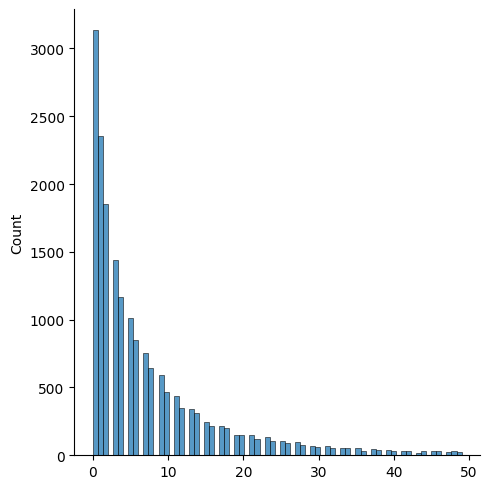

In [118]:
in_top_counts = {g: 0 for g in top_correlations.keys()}
for k, top in top_correlations.items():
    for n in top.index:
        in_top_counts[n] += 1
genes, counts = zip(*sorted(in_top_counts.items(), reverse=True, key=lambda t: t[1]))
#print(f'{genes[:10]}: {counts[:10]}')
sb.displot([c for c in counts if c < 50])
#pd.Series(in_top_count.values()).value_counts().loc[50]

In [72]:
#####
# Define a LudwigModel and train on ISPY Data
#####
config = load_json()

NameError: name 'trange' is not defined

In [6]:
#####
# Define a PyCaret Model, Train, and Evaluate 
#####
import pycaret.classification as pycls

pycaret_classifier = pycls.ClassificationExperiment()
pycaret_classifier.setup(scaled_ispy_data, target='PCR', session_id=123)

best = pycaret_classifier.compare_models()

,Description,Value
0,Session id,123
1,Target,PCR
2,Target type,Binary
3,Original data shape,"(69, 7001)"
4,Transformed data shape,"(69, 7001)"
5,Transformed train set shape,"(48, 7001)"
6,Transformed test set shape,"(21, 7001)"
7,Numeric features,7000
8,Rows with missing values,8.7%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8000,0.8500,0.8167,0.7267,0.7517,0.5683,0.5908,0.5400
nb,Naive Bayes,0.7950,0.7500,0.7667,0.7433,0.7317,0.5443,0.5690,0.4740
ridge,Ridge Classifier,0.7900,0.0000,0.7667,0.8433,0.7650,0.5488,0.5879,0.2750
rf,Random Forest Classifier,0.7800,0.7917,0.7333,0.7600,0.7083,0.5284,0.5596,0.3800
knn,K Neighbors Classifier,0.7550,0.7667,0.7667,0.6933,0.7150,0.4700,0.4836,0.5860
lightgbm,Light Gradient Boosting Machine,0.7550,0.8167,0.7333,0.7083,0.6824,0.4954,0.5377,0.3960
dt,Decision Tree Classifier,0.7350,0.7167,0.6667,0.7517,0.6683,0.4393,0.4523,0.3070
et,Extra Trees Classifier,0.7350,0.8083,0.7333,0.6933,0.6683,0.4399,0.4840,0.3810
lr,Logistic Regression,0.7100,0.8167,0.6667,0.7100,0.6583,0.3810,0.4025,0.7150
svm,SVM - Linear Kernel,0.6900,0.0000,0.7667,0.6333,0.6588,0.3622,0.3934,0.2740


In [22]:
### Load Data
ispy_alternate_arm = '../../Ludwig-ISPY2/Paclitaxel+Trastuzumab_scaled_dataset.tsv'
test_ispy_data = pd.read_csv(ispy_alternate_arm, sep='\t')
### Evaluate Predictions on test data original trial arm (Paclitaxel+Pembrolizumab)
base_predictions = pycaret_classifier.predict_model(best)
print(base_predictions['prediction_score'].describe())
### Evaluate Predictions on hold-out, new drug arm (Paclitaxel+Trastuzumab)
test_predictions = pycaret_classifier.predict_model(best, data=test_ispy_data)
print(test_predictions['prediction_score'].describe())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.5714,0.6806,0.5556,0.5000,0.5263,0.1370,0.1376


count    21.000000
mean      0.948190
std       0.126478
min       0.535400
25%       0.996200
50%       0.999900
75%       1.000000
max       1.000000
Name: prediction_score, dtype: float64


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7742,0.6902,0.6250,0.5556,0.5882,0.4334,0.4348


count    31.000000
mean      0.947232
std       0.120272
min       0.576400
25%       0.991400
50%       0.999600
75%       0.999900
max       1.000000
Name: prediction_score, dtype: float64


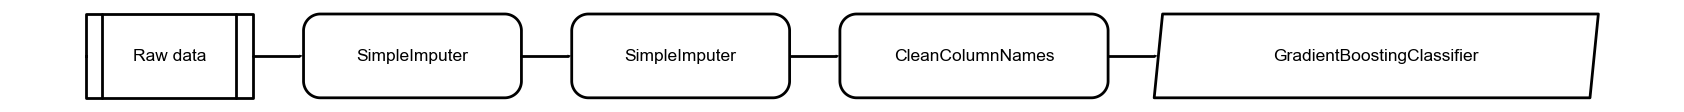

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

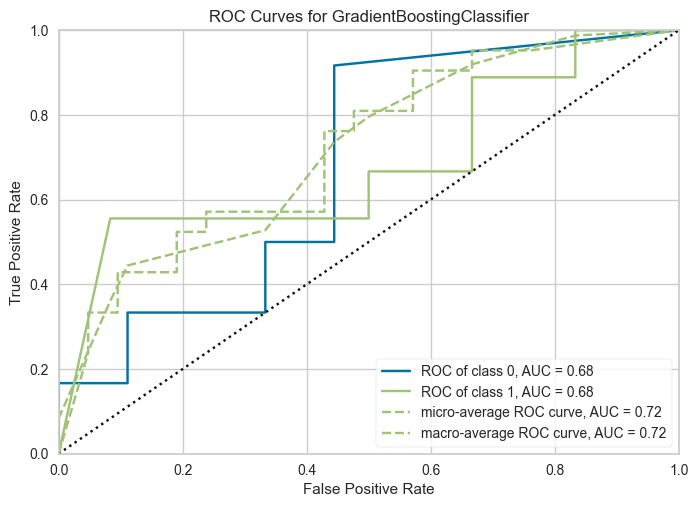

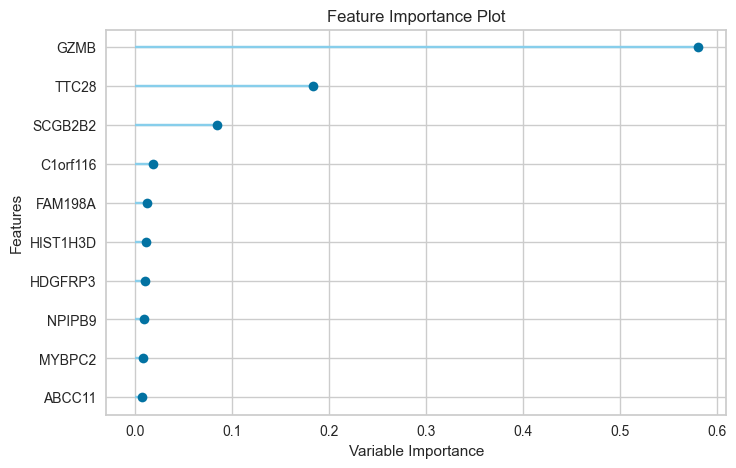

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.1
loss,log_loss
max_depth,3
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1


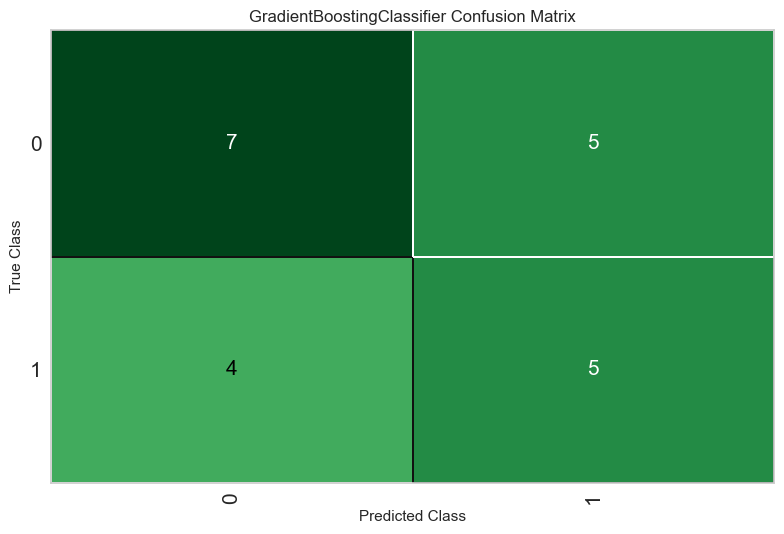

In [33]:
pycaret_classifier.plot_model(best, plot='auc')
pycaret_classifier.plot_model(best, plot='feature')
pycaret_classifier.plot_model(best, plot='parameter')
pycaret_classifier.plot_model(best, plot='confusion_matrix')

In [36]:
#####
# Define a PyCaret Model Using Feature Selection
#####
#import pycaret.classification as pycls

no_mult_classifier = pycls.ClassificationExperiment()
no_mult_classifier.setup(
    scaled_ispy_data, 
    target='PCR', 
    session_id=124,
    remove_multicollinearity=True
)
best_no_mult = no_mult_classifier.compare_models()

,Description,Value
0,Session id,124
1,Target,PCR
2,Target type,Binary
3,Original data shape,"(69, 7001)"
4,Transformed data shape,"(69, 6149)"
5,Transformed train set shape,"(48, 6149)"
6,Transformed test set shape,"(21, 6149)"
7,Numeric features,7000
8,Rows with missing values,8.7%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6850,0.6750,0.5167,0.5500,0.5100,0.3540,0.3802,1.2510
nb,Naive Bayes,0.6600,0.6917,0.6500,0.6233,0.5871,0.3284,0.3596,0.7910
et,Extra Trees Classifier,0.6600,0.7167,0.5167,0.5917,0.5267,0.3278,0.3279,0.8560
lr,Logistic Regression,0.6400,0.6667,0.5833,0.6167,0.5700,0.2796,0.2891,2.6230
knn,K Neighbors Classifier,0.6200,0.6792,0.6500,0.6083,0.6067,0.2591,0.2500,0.7630
ridge,Ridge Classifier,0.6200,0.0000,0.5833,0.5833,0.5500,0.2411,0.2558,0.9920
lda,Linear Discriminant Analysis,0.6200,0.6667,0.5333,0.5250,0.5124,0.2117,0.2225,0.7860
ada,Ada Boost Classifier,0.6150,0.7250,0.6167,0.5500,0.5600,0.2083,0.2356,0.9460
lightgbm,Light Gradient Boosting Machine,0.6100,0.7167,0.6333,0.6167,0.5933,0.2107,0.2466,1.0990
dt,Decision Tree Classifier,0.5550,0.5417,0.4000,0.5000,0.4200,0.0838,0.1056,1.0990


In [37]:
### Evaluate Predictions on test data original trial arm (Paclitaxel+Pembrolizumab)
base_predictions_no_mult = no_mult_classifier.predict_model(best_no_mult)
print(base_predictions_no_mult['prediction_score'].describe())
### Evaluate Predictions on hold-out, new drug arm (Paclitaxel+Trastuzumab)
test_predictions_no_mult = no_mult_classifier.predict_model(best_no_mult, data=test_ispy_data)
print(test_predictions_no_mult['prediction_score'].describe())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8571,0.9120,0.7778,0.8750,0.8235,0.7042,0.7077


count    21.000000
mean      0.647143
std       0.102330
min       0.510000
25%       0.550000
50%       0.660000
75%       0.720000
max       0.830000
Name: prediction_score, dtype: float64


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7742,0.6875,0.2500,0.6667,0.3636,0.2594,0.3057


count    31.000000
mean      0.652258
std       0.094259
min       0.500000
25%       0.580000
50%       0.630000
75%       0.710000
max       0.840000
Name: prediction_score, dtype: float64


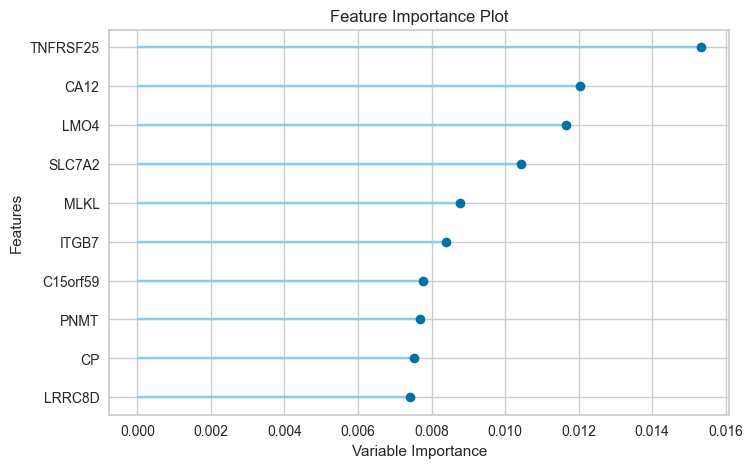

In [38]:
no_mult_classifier.plot_model(best_no_mult, plot='feature')

In [56]:
#train_statistic_file = '../../Ludwig-ISPY2/Paclitaxel+Pembrolizumab/results/experiment_run/training_statistics.json'
#test_statistic_file = '../../Ludwig-ISPY2/Paclitaxel+Pembrolizumab/results/experiment_run/test_statistics.json'
train_statistic_file = '../../Ludwig-ISPY2/AltConfig/results/experiment_run/training_statistics.json'
test_statistic_file = '../../Ludwig-ISPY2/AltConfig/results/experiment_run/test_statistics.json'

with open(train_statistic_file) as f:
    train_stats = json.load(f)
with open(test_statistic_file) as f:
    test_stats = json.load(f)
del train_statistic_file
del test_statistic_file

In [57]:
cm = test_stats['PCR']['confusion_matrix']

print(f'Accuracy: {test_stats["PCR"]["accuracy"]}')
print(f'ROC AUC: {test_stats["PCR"]["roc_auc"]}')
print(f'Precision: {cm[1][1]/(cm[1][1]+cm[0][1])}*')
print(f'Recall: {cm[1][1]/(cm[1][1]+cm[1][0])}*')
print(f'Confusion Matrix: {cm}')

Accuracy: 0.6458333730697632
ROC AUC: 0.625
Precision: 0.7142857142857143*
Recall: 0.625*
Confusion Matrix: [[4, 2], [3, 5]]


In [51]:
test_stats

{'PCR': {'accuracy': 0.4791666865348816,
  'confusion_matrix': [[2, 4], [3, 5]],
  'loss': 5.602840423583984,
  'overall_stats': {'avg_f1_score_macro': 0.47593582887700536,
   'avg_f1_score_micro': 0.5,
   'avg_f1_score_weighted': 0.4919786096256685,
   'avg_precision_macro': 0.4777777777777778,
   'avg_precision_micro': 0.5,
   'avg_precision_weighted': 0.5,
   'avg_recall_macro': 0.47916666666666663,
   'avg_recall_micro': 0.5,
   'avg_recall_weighted': 0.5,
   'kappa_score': -0.042553191489361764,
   'token_accuracy': 0.5},
  'per_class_stats': {'0': {'accuracy': 0.5,
    'f1_score': 0.3636363636363636,
    'fall_out': 0.375,
    'false_discovery_rate': 0.6,
    'false_negative_rate': 0.6666666666666667,
    'false_negatives': 4,
    'false_omission_rate': 0.4444444444444444,
    'false_positive_rate': 0.375,
    'false_positives': 3,
    'hit_rate': 0.3333333333333333,
    'informedness': -0.04166666666666674,
    'markedness': -0.0444444444444444,
    'matthews_correlation_coeffic